# Load Data and Word-Embedding Models

In [1]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('train_data.json', 'r'))
val_data = json.load(open('val_data.json', 'r'))
test_data = json.load(open('test_data.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [3]:
random_vector = {}
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('random')
        if size not in random_vector:
            random_vector[size] = torch.randn(size)
        return random_vector[size]

# GRU Implementation

In [4]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.gru = nn.GRU(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out


# Training and Validation Code

In [5]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {"B": 0, "I": 1, "O": 2}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"].split()
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda'):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B": 0, "I": 1, "O": 2}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 64  # Hidden size of the RNN
output_size = 3   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [9]:
gru_word2vec_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_word2vec_model.parameters(), lr=0.001)

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2742, Accuracy: 0.9147, F1: 0.6351
Validation: Loss: 0.1748, Accuracy: 0.9396, F1: 0.7449
Epoch 2/10
Training: Loss: 0.1715, Accuracy: 0.9413, F1: 0.7874
Validation: Loss: 0.1547, Accuracy: 0.9478, F1: 0.7837
Epoch 3/10
Training: Loss: 0.1425, Accuracy: 0.9510, F1: 0.8233
Validation: Loss: 0.1505, Accuracy: 0.9490, F1: 0.7882
Epoch 4/10
Training: Loss: 0.1208, Accuracy: 0.9566, F1: 0.8471
Validation: Loss: 0.1501, Accuracy: 0.9487, F1: 0.7902
Epoch 5/10
Training: Loss: 0.1021, Accuracy: 0.9616, F1: 0.8697
Validation: Loss: 0.1519, Accuracy: 0.9490, F1: 0.7930
Epoch 6/10
Training: Loss: 0.0852, Accuracy: 0.9674, F1: 0.8932
Validation: Loss: 0.1580, Accuracy: 0.9478, F1: 0.7911
Epoch 7/10
Training: Loss: 0.0696, Accuracy: 0.9737, F1: 0.9178
Validation: Loss: 0.1600, Accuracy: 0.9487, F1: 0.7971
Epoch 8/10
Training: Loss: 0.0555, Accuracy: 0.9787, F1: 0.9355
Validation: Loss: 0.1668, Accuracy: 0.9483, F1: 0.7970
Epoch 9/10
Training: Loss: 0.0426, Accuracy: 0.9

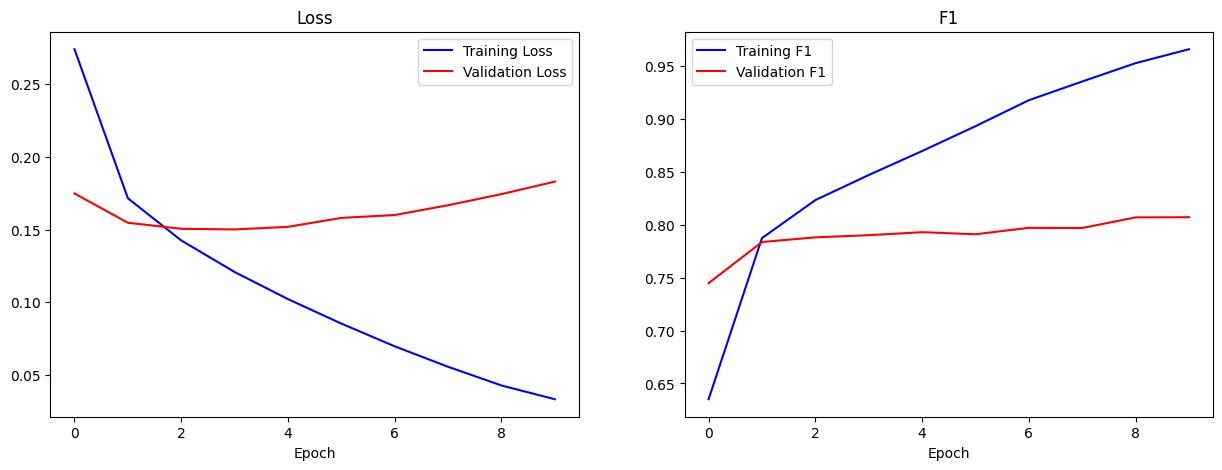

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [13]:
torch.save(gru_word2vec_model, "t2_model3_word2vec.pt")

In [18]:
test_accuracy, test_f1 = test("t2_model3_word2vec.pt", word2vec, test_data, device='cuda')
print(("GRU with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

GRU with Word2Vec ==> Accuracy: 0.9279, F1: 0.7698


# For GloVe Embeddings

In [19]:
gru_glove_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_glove_model.parameters(), lr=0.001)

In [20]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2866, Accuracy: 0.9156, F1: 0.6190
Validation: Loss: 0.1940, Accuracy: 0.9358, F1: 0.7022
Epoch 2/10
Training: Loss: 0.2021, Accuracy: 0.9343, F1: 0.7423
Validation: Loss: 0.1783, Accuracy: 0.9396, F1: 0.7382
Epoch 3/10
Training: Loss: 0.1667, Accuracy: 0.9434, F1: 0.7852
Validation: Loss: 0.1740, Accuracy: 0.9408, F1: 0.7521
Epoch 4/10
Training: Loss: 0.1390, Accuracy: 0.9526, F1: 0.8275
Validation: Loss: 0.1755, Accuracy: 0.9425, F1: 0.7688
Epoch 5/10
Training: Loss: 0.1174, Accuracy: 0.9595, F1: 0.8557
Validation: Loss: 0.1824, Accuracy: 0.9418, F1: 0.7602
Epoch 6/10
Training: Loss: 0.0994, Accuracy: 0.9662, F1: 0.8851
Validation: Loss: 0.1878, Accuracy: 0.9413, F1: 0.7621
Epoch 7/10
Training: Loss: 0.0845, Accuracy: 0.9724, F1: 0.9103
Validation: Loss: 0.1955, Accuracy: 0.9396, F1: 0.7624
Epoch 8/10
Training: Loss: 0.0742, Accuracy: 0.9768, F1: 0.9250
Validation: Loss: 0.2092, Accuracy: 0.9368, F1: 0.7602
Epoch 9/10
Training: Loss: 0.0653, Accuracy: 0.9

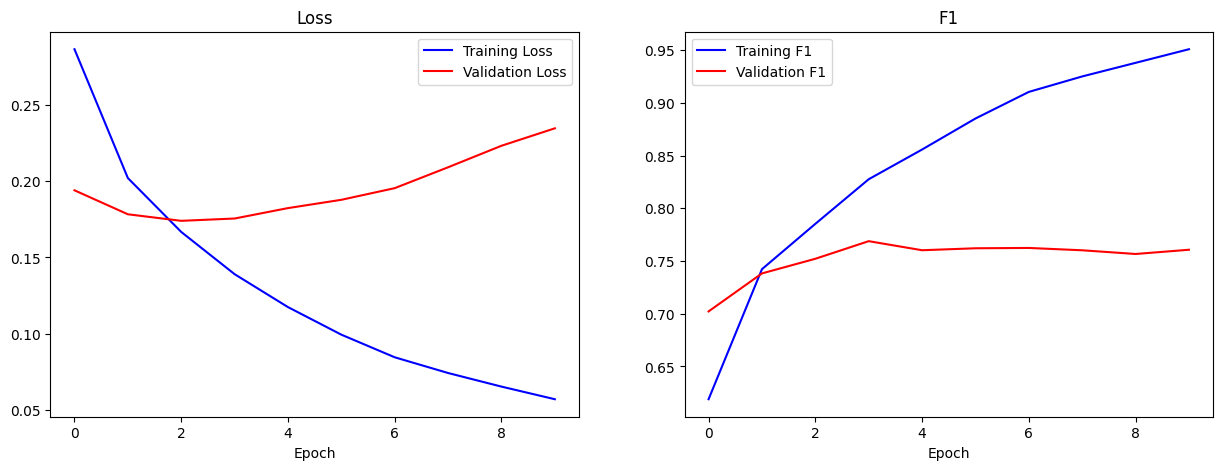

In [21]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [23]:
torch.save(gru_glove_model, "t2_model3_glove.pt")

In [27]:
test_accuracy, test_f1 = test("t2_model3_glove.pt", glove, test_data, device='cuda')
print(("GRU with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

GRU with GloVe ==> Accuracy: 0.9126, F1: 0.7150


# For FastText Embeddings

In [29]:
gru_fasttext_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_fasttext_model.parameters(), lr=0.001)

In [31]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        gru_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2848, Accuracy: 0.9133, F1: 0.6015
Validation: Loss: 0.1757, Accuracy: 0.9372, F1: 0.7093
Epoch 2/10
Training: Loss: 0.1767, Accuracy: 0.9364, F1: 0.7620
Validation: Loss: 0.1530, Accuracy: 0.9468, F1: 0.7709
Epoch 3/10
Training: Loss: 0.1529, Accuracy: 0.9449, F1: 0.7970
Validation: Loss: 0.1462, Accuracy: 0.9468, F1: 0.7728
Epoch 4/10
Training: Loss: 0.1379, Accuracy: 0.9502, F1: 0.8214
Validation: Loss: 0.1443, Accuracy: 0.9468, F1: 0.7777
Epoch 5/10
Training: Loss: 0.1257, Accuracy: 0.9536, F1: 0.8376
Validation: Loss: 0.1460, Accuracy: 0.9449, F1: 0.7747
Epoch 6/10
Training: Loss: 0.1147, Accuracy: 0.9567, F1: 0.8503
Validation: Loss: 0.1492, Accuracy: 0.9451, F1: 0.7756
Epoch 7/10
Training: Loss: 0.1043, Accuracy: 0.9599, F1: 0.8648
Validation: Loss: 0.1549, Accuracy: 0.9466, F1: 0.7856
Epoch 8/10
Training: Loss: 0.0943, Accuracy: 0.9636, F1: 0.8801
Validation: Loss: 0.1607, Accuracy: 0.9463, F1: 0.7820
Epoch 9/10
Training: Loss: 0.0845, Accuracy: 0.9

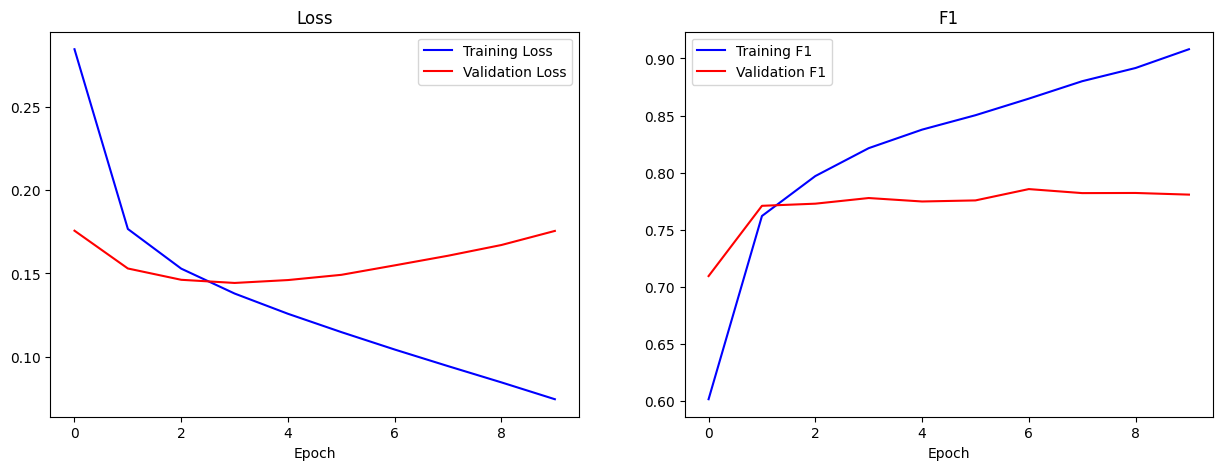

In [32]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [33]:
torch.save(gru_fasttext_model, "t2_model3_fasttext.pt")

In [37]:
test_accuracy, test_f1 = test("t2_model3_fasttext.pt", fasttext, test_data, device='cuda')
print(("GRU with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

GRU with FastText ==> Accuracy: 0.9296, F1: 0.7785
